# Keras Seqeuntial Artifical Neural Network (Output: ReLU/Sigmoid Activation) for Market Trading - updated 12/03/2022 ver 2.0

## <i> i.) Import Libraries and Dependencies </i>

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import re

In [2]:
# Import Keras ANN Modeling Libraries & Sklearn Preprocessing Modules
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset

# Import Keras ANN Dropout & Regularizer Build Processing Modules
# Import dropout
from keras.layers import Dropout
# Import regularizers
from keras.regularizers import l1, l2

2022-12-06 19:08:09.209811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <i> ii.) Prepare the DataFrames </i>

In [3]:
# Get filename from dir and store as 'algoData_asset' for each individual asset file to use later in labelling/filenaming
filename = Path("../Datasets/algoData_ETH-USD.csv")

display(os.path.basename(filename))
display(os.path.dirname(filename))
display(os.path.splitext(filename))
display(os.path.splitext(os.path.basename(filename)))
algoData_asset = os.path.splitext(os.path.basename(filename))
algoData_asset = algoData_asset[0] 
algoData_asset = algoData_asset.split('_')
algoData_asset = algoData_asset[1]
print(algoData_asset)

#print(os.path.splitext(filename))

'algoData_ETH-USD.csv'

'../Datasets'

('../Datasets/algoData_ETH-USD', '.csv')

('algoData_ETH-USD', '.csv')

ETH-USD


In [4]:
# Confirm algoData_asset is type(str)
type(algoData_asset)

str

In [5]:
#Import .csv file as dataframe and shift 'ActualReturns' column forward .shift() 
#to re-align to neutral (as the 'Signal' column and 'ActualReturns' are both shifted backed (.shift(-1)) in the raw .csv file

# Import filename & conver to dataframe
df = pd.read_csv(filename, 
                index_col='Date', 
                parse_dates=True,
                infer_datetime_format=True)
display(df.head(3))
display(df.tail(3))

# Create empty dataframe for 'ActualReturns' column and shift(+1) to realign to neutral timeseries index position
actual_returns_shift_df = pd.DataFrame()
actual_returns_shift_df['Norm Actual Returns'] = df['ActualReturns'].shift()

,Ticker,Date.1,Open,High,Low,Close,Volume,ActualReturns,Signal,EMAShort,...,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26 00:00:00+00:00,ETH-USD,2018-01-26 00:00:00+00:00,1052.699951,1080.599976,996.783997,1055.170044,3617690112,0.049186,1.0,1069.627501,...,-3.152493,0.083257,12.415241,1.538432,1.006433,0.747830,0.065545,32.981887,-30.537604,63.519491
2018-01-27 00:00:00+00:00,ETH-USD,2018-01-27 00:00:00+00:00,1055.750000,1121.979980,1042.119995,1107.069946,3002870016,0.125503,1.0,1075.387877,...,-4.460682,0.096773,13.020779,1.544635,1.043657,0.788062,0.058593,33.525488,-23.995203,57.520691
2018-01-28 00:00:00+00:00,ETH-USD,2018-01-28 00:00:00+00:00,1111.780029,1257.770020,1111.780029,1246.010010,5372329984,-0.051083,-1.0,1101.637436,...,-1.967458,0.131167,15.450160,1.668921,1.156740,0.885107,0.049260,44.652867,-10.294259,54.947126


,Ticker,Date.1,Open,High,Low,Close,Volume,ActualReturns,Signal,EMAShort,...,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-28 00:00:00+00:00,ETH-USD,2022-10-28 00:00:00+00:00,1514.323120,1568.633911,1493.871094,1555.477905,19974623205,0.041287,1.0,1420.806394,...,11.252625,0.729619,-1.597395,1.308656,1.158599,1.039415,0.014743,37.624908,34.287752,3.337156
2022-10-29 00:00:00+00:00,ETH-USD,2022-10-29 00:00:00+00:00,1555.274658,1652.382202,1549.983643,1619.698486,21618154775,-0.017852,-1.0,1451.405177,...,12.721712,0.853120,-1.987739,1.385798,1.197985,1.055004,0.016735,50.703914,37.893406,12.810507
2022-10-30 00:00:00+00:00,ETH-USD,2022-10-30 00:00:00+00:00,1619.697876,1637.037842,1579.485229,1590.783325,13930073427,-0.011358,-1.0,1472.847969,...,9.583658,0.683069,-3.708408,1.372775,1.169024,1.017939,0.018660,58.066553,36.204837,21.861716


In [6]:
actual_returns_shift_df = actual_returns_shift_df.dropna()

In [7]:
display(actual_returns_shift_df)

,Norm Actual Returns
Date,
2018-01-27 00:00:00+00:00,0.049186
2018-01-28 00:00:00+00:00,0.125503
2018-01-29 00:00:00+00:00,-0.051083
2018-01-30 00:00:00+00:00,-0.094075
2018-01-31 00:00:00+00:00,0.044047
...,...
2022-10-26 00:00:00+00:00,0.071768
2022-10-27 00:00:00+00:00,-0.033316
2022-10-28 00:00:00+00:00,0.027142


In [8]:
# Create list for non-normalized columns to be dropped out if required
%pprint
col_names = list(df.columns.values)
display(col_names)
display(f"Number of unique columns: {len(col_names)}")

Pretty printing has been turned OFF


['Ticker', 'Date.1', 'Open', 'High', 'Low', 'Close', 'Volume', 'ActualReturns', 'Signal', 'EMAShort', 'EMALong', 'RSIline', 'MOMline', 'ROCline', 'SMAline', 'lowerBB', 'middleBB', 'upperBB', '2stdBB', 'MACDline', 'MACDHistogram', 'MACDSignal', 'EMAShort_zscore', 'EMALong_zscore', 'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore', 'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', 'upperBB_zscore', '2stdBB_zscore', 'MACDline_zscore', 'MACDHistogram_zscore', 'MACDSignal_zscore', 'EMAShort_normal', 'EMALong_normal', 'RSIline_normal', 'MOMline_normal', 'ROCline_normal', 'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', '2stdBB_normal', 'MACDline_normal', 'MACDHistogram_normal', 'MACDSignal_normal']

'Number of unique columns: 48'

## <i> ii.) Split Data into Training & Test Sets </i>

In [9]:
# Create X features dataframe
# Drop non-normalized & pre-Zscore calculated column values
# Drop all Bear & Bull signals for Elder Ray as they do not apply to forex strategy only
# I.e. 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', '2stdBB_normal'

must_drop_feat = ['Ticker', 'Date.1']

OHLCV = ['Open', 'High', 'Low', 'Close', 'Volume'] 

standard_feat = ['EMAShort', 'EMALong', 'RSIline', 'MOMline', 'ROCline', 'SMAline', 'lowerBB', \
                 'middleBB', 'upperBB', '2stdBB', 'MACDline', 'MACDHistogram', 'MACDSignal']

normal_feat = ['EMAShort_normal', 'EMALong_normal', 'RSIline_normal', 'MOMline_normal', 'ROCline_normal', \
               'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', \
               '2stdBB_normal', 'MACDline_normal', 'MACDHistogram_normal', 'MACDSignal_normal']

zscore_feat = ['EMAShort_zscore', 'EMALong_zscore', 'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore', \
               'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', 'upperBB_zscore', \
               '2stdBB_zscore', 'MACDline_zscore', 'MACDHistogram_zscore', 'MACDSignal_zscore']



X = df.copy()
X = X.drop(columns = zscore_feat)
X = X.drop(columns = standard_feat)
X = X.drop(columns = OHLCV)
X = X.drop(columns = must_drop_feat)
#X = X.drop(columns = normal_feat)
X['ActualReturns'] = actual_returns_shift_df['Norm Actual Returns']
X = X.dropna()
y = X[['Signal']]
X = X.drop(columns = ['Signal'])

display(f"Number of included columns in final X-features: {len(X.columns)}")
display(X)
display(y)

'Number of included columns in final X-features: 14'

,ActualReturns,EMAShort_normal,EMALong_normal,RSIline_normal,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,
2018-01-27 00:00:00+00:00,0.049186,5.760376,5.216470,0.845051,-4.460682,0.096773,13.020779,1.544635,1.043657,0.788062,0.058593,33.525488,-23.995203,57.520691
2018-01-28 00:00:00+00:00,0.125503,26.249559,15.121921,1.011984,-1.967458,0.131167,15.450160,1.668921,1.156740,0.885107,0.049260,44.652867,-10.294259,54.947126
2018-01-29 00:00:00+00:00,-0.051083,12.418854,9.286963,1.033305,-1.967835,0.052905,14.812780,1.499504,1.082076,0.846445,0.047088,47.784539,-5.730069,53.514608
2018-01-30 00:00:00+00:00,-0.094075,-6.604044,0.359782,1.003440,0.346444,-0.349401,11.119880,1.297566,0.970968,0.775719,0.046997,40.820529,-10.155264,50.975793
2018-01-31 00:00:00+00:00,0.044047,1.670433,3.827950,1.188800,2.328603,-0.245029,9.337581,1.291923,1.003257,0.820030,0.039960,38.662855,-9.850350,48.513205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-26 00:00:00+00:00,0.071768,34.856434,16.701364,4.211810,15.820974,0.920081,0.096362,1.289326,1.178632,1.085442,0.010961,17.056658,30.330859,-13.274201
2022-10-27 00:00:00+00:00,-0.033316,21.464402,11.598168,3.287416,11.436427,0.608291,-2.310630,1.258623,1.134124,1.032038,0.013064,26.922892,32.157675,-5.234782
2022-10-28 00:00:00+00:00,0.027142,24.485729,13.783714,2.955918,11.252625,0.729619,-1.597395,1.308656,1.158599,1.039415,0.014743,37.624908,34.287752,3.337156


,Signal
Date,
2018-01-27 00:00:00+00:00,1.0
2018-01-28 00:00:00+00:00,-1.0
2018-01-29 00:00:00+00:00,-1.0
2018-01-30 00:00:00+00:00,1.0
2018-01-31 00:00:00+00:00,-1.0
...,...
2022-10-26 00:00:00+00:00,-1.0
2022-10-27 00:00:00+00:00,1.0
2022-10-28 00:00:00+00:00,1.0


In [10]:
# Splitting Datasets Using 145 Week Groupings
# Select trading begin
training_begin = X.index.min()
print(f"Training begin: {training_begin}.")

# Select trading end
# Note: months = 145 for all assets except ETH-USD (months= 14)
# Note: months = 145 for all assets except BTC-USD (months= 70)
training_end = X.index.min() + DateOffset(months = 14)
print(f"Training end: {training_end}.")

X_train = X.loc[training_begin:training_end] 
y_train = y.loc[training_begin:training_end] 

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Create Dataframe just to hold 'ActualReturns' values for end of calculations
X_ActualReturns = actual_returns_shift_df.loc[training_end:]
                
#Also save a second X_test_aligned_index for final dataframe
X_test_aligned_index = X.loc[training_end:]

Training begin: 2018-01-27 00:00:00+00:00.
Training end: 2019-03-27 00:00:00+00:00.


In [11]:
# Test output y_train
y_train

,Signal
Date,
2018-01-27 00:00:00+00:00,1.0
2018-01-28 00:00:00+00:00,-1.0
2018-01-29 00:00:00+00:00,-1.0
2018-01-30 00:00:00+00:00,1.0
2018-01-31 00:00:00+00:00,-1.0
...,...
2019-03-23 00:00:00+00:00,-1.0
2019-03-24 00:00:00+00:00,-1.0
2019-03-25 00:00:00+00:00,1.0


In [12]:
# Test output y_test
y_test

,Signal
Date,
2019-03-27 00:00:00+00:00,-1.0
2019-03-28 00:00:00+00:00,1.0
2019-03-29 00:00:00+00:00,-1.0
2019-03-30 00:00:00+00:00,-1.0
2019-03-31 00:00:00+00:00,1.0
...,...
2022-10-26 00:00:00+00:00,-1.0
2022-10-27 00:00:00+00:00,1.0
2022-10-28 00:00:00+00:00,1.0


In [13]:
# Function to convert all sell signals (-1) to be compatible with the output sigmoid activation function

def convert_neg(y_df):
    for i in (range(len(y_df))):
        if (y_df['Signal'][i] == -1):
            y_df['Signal'][i] = 0
        
    return y_df

In [14]:
y_train.copy()
y_train = convert_neg(y_train)

/Users/chris/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
y_test.copy()
y_test = convert_neg(y_test)

/Users/chris/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Re-test output y_train after -1->0 conversion for sigmoid output compatiblity 
y_train

,Signal
Date,
2018-01-27 00:00:00+00:00,1.0
2018-01-28 00:00:00+00:00,0.0
2018-01-29 00:00:00+00:00,0.0
2018-01-30 00:00:00+00:00,1.0
2018-01-31 00:00:00+00:00,0.0
...,...
2019-03-23 00:00:00+00:00,0.0
2019-03-24 00:00:00+00:00,0.0
2019-03-25 00:00:00+00:00,1.0


In [17]:
# Re-test output y_test after -1->0 conversion for sigmoid output compatiblity 
y_test

,Signal
Date,
2019-03-27 00:00:00+00:00,0.0
2019-03-28 00:00:00+00:00,1.0
2019-03-29 00:00:00+00:00,0.0
2019-03-30 00:00:00+00:00,0.0
2019-03-31 00:00:00+00:00,1.0
...,...
2022-10-26 00:00:00+00:00,0.0
2022-10-27 00:00:00+00:00,1.0
2022-10-28 00:00:00+00:00,1.0


In [18]:
# Training & Test Set Dimensions

display(f"X Dataframe shape: {X.shape}.")
display(f"y Dataframe shape: {y.shape}.")
display(f"X_train Dataframe shape: {X_train.shape}.")
display(f"y_train shape: {y_train.shape}.")
display(f"X_test Dataframe shape: {X_test.shape}.")
display(f"y_test shape: {y_test.shape}.")

'X Dataframe shape: (1738, 14).'

'y Dataframe shape: (1738, 1).'

'X_train Dataframe shape: (425, 14).'

'y_train shape: (425, 1).'

'X_test Dataframe shape: (1314, 14).'

'y_test shape: (1314, 1).'

In [19]:
# Convert y_train/y_test dataframe ['Signal'] columns values to array for Keras Sequential fitting 

y_train = y_train['Signal'].values
display(y_train[0:3])
display(y_train[-1])
y_test = y_test['Signal'].values
display(y_test[0:3])
display(y_test[-1])

array([1., 0., 0.])

0.0

array([0., 1., 0.])

0.0

In [20]:
# Finalize the y_train & y_test data into a trainable array
# Reshape into vertical vectors for use in Sequential Model algorithm

#y_train = y_train['Signal'].values.astype("int32")
#y_train = y_train.reshape(-1,1).astype("int32")
y_train = y_train.reshape(-1,1).astype("int32")

#y_test = y_test['Signal'].values.astype("int32")
y_test = y_test.reshape(-1,1).astype("int32")


display((f"Number of final X_test features to run into ANN: {len(X_test.columns)}."))
display(y_train[0:10])
display(y_test[0:10])

'Number of final X_test features to run into ANN: 14.'

array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

array([[0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [21]:
# Create the StandardScaler instance
X_scaler = StandardScaler()
#X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train),columns =X_train.columns)
#X_test_scaled = pd.DataFrame(X_scaler.fit_transform(X_test),columns =X_test.columns)

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Display X_train_scaled & X_test_scaled shapes
display(f"X_train_scaled shape: {X_train_scaled.shape}")
display(f"X_train_scaled shape: {X_test_scaled.shape}")

'X_train_scaled shape: (425, 14)'

'X_train_scaled shape: (1314, 14)'

## <i> iii.) Constructing the ANN Model Using Sequential Model </i>

### <i> Defining the Input Parameters to the ANN: </i>

In [22]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
display(f"Number of input features (N_i): {number_input_features}.")

# Define the number of neurons in the output layer
number_output_neurons = 1
display(f"Number of output features (N_o): {number_output_neurons}.")

# Calculating optimal hidden layer neurons to use per layer (first layer primary)
# (Calculation code frame added by me 11/12/2022)

# N_h: Number of hidden layer neurons
N_h = 0

# N_i: Number of input neurons
N_i = number_input_features
display(f"N_i: {N_i}")

# N_o: Number of output neurons
N_o = number_output_neurons
display(f"N_o: {N_o}")

# N_s: Number of samples in training data set
N_s = len(X_train)
display(f"N_s: {N_s}")

# alpha_: Arbitrary scaler between (2-10)
alpha_ = 6
display(f"alpha_: {alpha_}")

# Calculate the new value of N_h:
print()
N_h = int(round((N_s / (alpha_ * (N_i + N_o))),0))
display(f"Final ideal value of N_h (ideal number of hidden nodes in [minimal] first layer) should be: {N_h}.")

'Number of input features (N_i): 14.'

'Number of output features (N_o): 1.'

'N_i: 14'

'N_o: 1'

'N_s: 425'

'alpha_: 6'

'Final ideal value of N_h (ideal number of hidden nodes in [minimal] first layer) should be: 5.'

In [23]:
# Define the number of hidden nodes for the first hidden layer
#hidden_nodes_layer1 = N_h

#hidden_nodes_layer1 = N_h
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 8

# Review the number of hidden nodes in the first layer
display(f"Number of hidden node layers (layer 1): {hidden_nodes_layer1}.")

# Instantiate the Artificial Neural Network 'Sequential' Model

nn = Sequential()

# Add LSTM (Long-short term memory layer)

#nn.add(LSTM(units=10, activation="relu", input_shape=(X_train_scaled.shape[0], X_train_scaled.shape[1])))

# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(Dense(units=(hidden_nodes_layer2), activation="relu"))

# Third hidden layer
nn.add(Dense(units=(hidden_nodes_layer3), activation="relu"))

# Fourth layer becomes dropout layer
#model.add(Dropout(.2,input_shape=(10,)))
#nn.add(Dropout(.1,input_shape=(number_input_features,)))

# Fifth layer to add regularizer layering to the model
#nn.add(Dense(5, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
nn.add(Dense(units=(14), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# Output layer
nn.add(Dense(units=1, activation="sigmoid"))


# Check the structure of the model
nn.summary()

'Number of hidden node layers (layer 1): 8.'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 120       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 14)                126       
                                                                 
 dense_4 (Dense)             (None, 1)                 15        
                                                                 
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


2022-12-06 19:08:20.512763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fit model on X_train_scaled data
Epoch 1/275
2/2 - 1s - loss: 0.8656 - accuracy: 0.5365 - 973ms/epoch - 487ms/step
Epoch 2/275
2/2 - 0s - loss: 0.8556 - accuracy: 0.5435 - 14ms/epoch - 7ms/step
Epoch 3/275
2/2 - 0s - loss: 0.8467 - accuracy: 0.5435 - 19ms/epoch - 10ms/step
Epoch 4/275
2/2 - 0s - loss: 0.8387 - accuracy: 0.5459 - 11ms/epoch - 6ms/step
Epoch 5/275
2/2 - 0s - loss: 0.8314 - accuracy: 0.5435 - 20ms/epoch - 10ms/step
Epoch 6/275
2/2 - 0s - loss: 0.8248 - accuracy: 0.5506 - 15ms/epoch - 7ms/step
Epoch 7/275
2/2 - 0s - loss: 0.8188 - accuracy: 0.5459 - 11ms/epoch - 5ms/step
Epoch 8/275
2/2 - 0s - loss: 0.8134 - accuracy: 0.5506 - 17ms/epoch - 9ms/step
Epoch 9/275
2/2 - 0s - loss: 0.8086 - accuracy: 0.5435 - 16ms/epoch - 8ms/step
Epoch 10/275
2/2 - 0s - loss: 0.8043 - accuracy: 0.5459 - 16ms/epoch - 8ms/step
Epoch 11/275
2/2 - 0s - loss: 0.8003 - accuracy: 0.5388 - 13ms/epoch - 6ms/step
Epoch 12/275
2/2 - 0s - loss: 0.7969 - accuracy: 0.5435 - 14ms/epoch - 7ms/step
Epoch 13/27

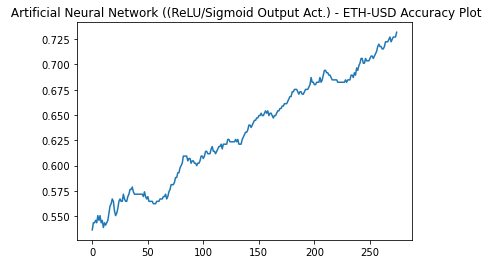

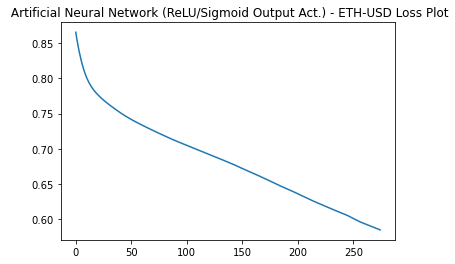

In [24]:
# Compile the Sequential Model
#nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model using 50 epochs and the training data
# 1 epoch = when all samples (images) go through an entire iteration
# batch size = fraction of the entire sample X_train data to be sent through one epoch
# [epoch/batch_size = iterations per epoch] 
# 1 epoch when all samples go through forward/backward iteration

print("Fit model on X_train_scaled data")
fit_model = nn.fit(X_train_scaled, y_train, epochs=275, verbose=2, batch_size=256, shuffle=False)

# Plot the Output of the fit_model history
fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
fig2, ax2 = plt.subplots(1) # Another figure

ax.set_title(f' Artificial Neural Network ((ReLU/Sigmoid Output Act.) - {algoData_asset} Accuracy Plot')
ax.plot(fit_model.history['accuracy'], label='train')
fig.savefig(f'../Datasets/algoData_ANN_model_acc_loss/{algoData_asset}_ann_accuracy_.png')


ax2.set_title(f' Artificial Neural Network (ReLU/Sigmoid Output Act.) - {algoData_asset} Loss Plot')
ax2.plot(fit_model.history['loss'], label='train')
fig2.savefig(f'../Datasets/algoData_ANN_model_acc_loss/{algoData_asset}_ann_loss_.png')

In [25]:
# Evaluate the model using testing data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, y_train, verbose=2)

# Display evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

14/14 - 0s - loss: 0.5842 - accuracy: 0.7318 - 328ms/epoch - 23ms/step
Loss: 0.5842174291610718, Accuracy: 0.7317647337913513


In [26]:
# Evaluate the model using testing data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

42/42 - 0s - loss: 1.3771 - accuracy: 0.5015 - 92ms/epoch - 2ms/step
Loss: 1.3771488666534424, Accuracy: 0.5015220642089844


In [27]:
# Predict on X_test, y_test datasets

print("Evaluate model on X_test_scaled data")
#predictions = nn.predict(X_test_scaled).astype("int32")
predictions = (nn.predict(X_test_scaled) > 0.51).astype("int32")

Evaluate model on X_test_scaled data
42/42 [==============================] - 0s 2ms/step


In [28]:
display(predictions[0:10])

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [29]:
y_test = y_test.flatten()

In [30]:
results = pd.DataFrame({"predictions": predictions.flatten(), "actual": y_test.flatten()})
#results = pd.DataFrame({"predictions": predictions.ravel(), "actual": y_test}, index=[0])
display(results.value_counts())
display(results.head(10))
display(results.tail(10))

predictions  actual
0            1         554
             0         525
1            1         135
             0         100
dtype: int64

,predictions,actual
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
5,0,1
6,0,0
7,0,0
8,0,1
9,0,1


,predictions,actual
1304,0,1
1305,0,1
1306,0,0
1307,0,1
1308,0,1
1309,0,0
1310,0,1
1311,0,1
1312,0,0
1313,0,0


In [31]:
# Function to convert all -1 to 0

def convert_back_to_neg(y_df):
    for i in (range(len(y_df))):
        if (y_df['predictions'][i] == 0):
            y_df['predictions'][i] = -1
        
    return y_df

In [32]:
results.copy()
results = convert_back_to_neg(results)

In [33]:
results

,predictions,actual
0,-1,0
1,-1,1
2,-1,0
3,-1,0
4,-1,1
...,...,...
1309,-1,0
1310,-1,1
1311,-1,1
1312,-1,0


In [34]:
results.value_counts()

predictions  actual
-1           1         554
             0         525
 1           1         135
             0         100
dtype: int64

In [35]:
# Get the original Actual Returns column from the original imported dataset

df_final = df[['ActualReturns']]
df_final = df_final.loc[training_end:]
df_final

,ActualReturns
Date,
2019-03-27 00:00:00+00:00,-0.011148
2019-03-28 00:00:00+00:00,0.022099
2019-03-29 00:00:00+00:00,-0.002840
2019-03-30 00:00:00+00:00,-0.004072
2019-03-31 00:00:00+00:00,0.002235
...,...
2022-10-26 00:00:00+00:00,-0.033316
2022-10-27 00:00:00+00:00,0.027142
2022-10-28 00:00:00+00:00,0.041287


In [36]:
# Create function to compile cumulative returns for Artificial Neural Network Predicted y_test values

def annReturns(results, X_test):

    # Make emtpy dataframe to store actual returns, predictions & cumulative returns
    
    # Inititialize first return 0 so cumulative ret begins at base 1
    #annData['Actual Returns'][0] = 0
    
    annData = pd.DataFrame()
    annData.index = X_test.index
    results.index = X_test.index
    annData['Prediction_Signal'] = results['predictions'] 
    annData['Actual_Returns'] = df_final['ActualReturns'].values
    annData['annStrategyReturns'] = annData['Actual_Returns'] * annData['Prediction_Signal'] 
    annData['cumActual_Returns'] = (1 + annData['Actual_Returns']).cumprod()
    annData['cumANNStrategyReturns'] = (1 + annData['annStrategyReturns']).cumprod()
    
    returns = annData
    
    return returns

In [37]:
# Run annReturns Function and display sample final cumulative returns dataframe

returns_df = annReturns(results, X_test)
display(returns_df.head(5))
display(returns_df.tail(5))

,Prediction_Signal,Actual_Returns,annStrategyReturns,cumActual_Returns,cumANNStrategyReturns
Date,,,,,
2019-03-27 00:00:00+00:00,-1,-0.011148,0.011148,0.988852,1.011148
2019-03-28 00:00:00+00:00,-1,0.022099,-0.022099,1.010705,0.988802
2019-03-29 00:00:00+00:00,-1,-0.002840,0.002840,1.007834,0.991611
2019-03-30 00:00:00+00:00,-1,-0.004072,0.004072,1.003730,0.995649
2019-03-31 00:00:00+00:00,-1,0.002235,-0.002235,1.005973,0.993424


,Prediction_Signal,Actual_Returns,annStrategyReturns,cumActual_Returns,cumANNStrategyReturns
Date,,,,,
2022-10-26 00:00:00+00:00,-1,-0.033316,0.033316,10.741149,0.051523
2022-10-27 00:00:00+00:00,-1,0.027142,-0.027142,11.032685,0.050125
2022-10-28 00:00:00+00:00,-1,0.041287,-0.041287,11.488188,0.048056
2022-10-29 00:00:00+00:00,-1,-0.017852,0.017852,11.283099,0.048913
2022-10-30 00:00:00+00:00,-1,-0.011358,0.011358,11.154940,0.049469


In [38]:
# Save Results to External .csv File
# Save Finalized Output 'returns_df' dataframe

returns_df.to_csv(f'../Datasets/algoData_ANN_results/{algoData_asset}_ANN_results.csv', index=True)